In [93]:
import pickle
import healpy as hp
import numpy as np

f = open(f"/Users/akotamraju/Documents/dev/URAP/main-responseapprox/data/cross-sec-data/FlatContinuumIsotropic.inc520.id1.tra.gz.pkl", "rb");
vals = pickle.load(f)
f.close()

y_arr = np.array(vals['y'])
healpix_arr = y_arr[6]

NSIDE = 128

print(y_arr.shape)

# Uncomment following to show proof of concept 
# healpix_arr = np.array(list(range(NSIDE**2 * 12)))

(36, 196608)


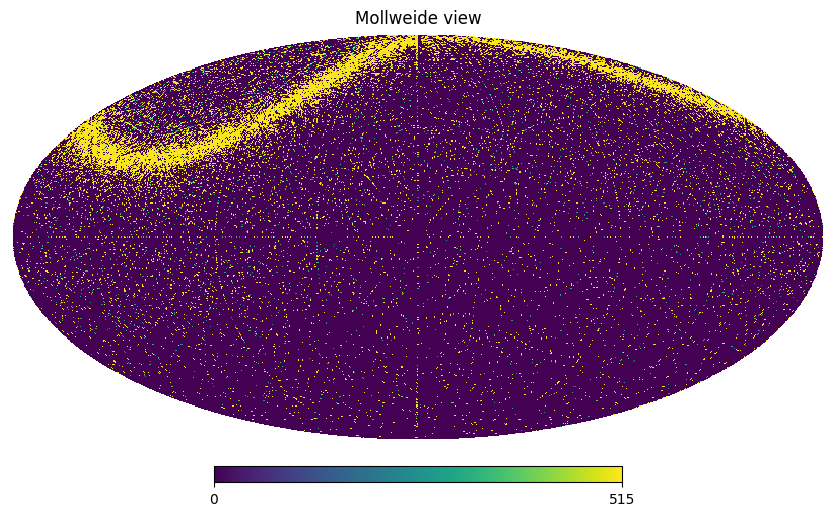

In [94]:
hp.mollview(healpix_arr)

(768, 1024)


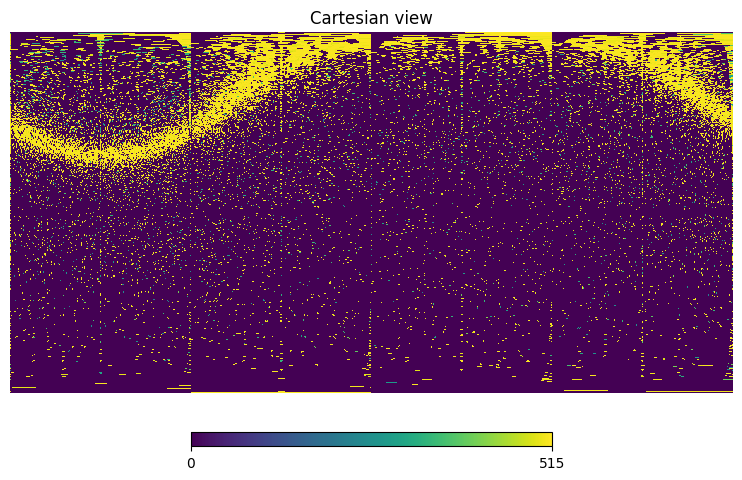

In [95]:
x_dim = 1024
y_dim = 768
cart_arr = hp.cartview(healpix_arr, xsize=x_dim, ysize=y_dim, return_projected_map=True)
print(cart_arr.shape)

In [96]:
import matplotlib.pyplot as plt

import sys
sys.path.append('../utils')

from mapping import reconstruct_from_cartesian

# Load the position map
with open(f'../../mappings/NSIDE_{NSIDE}_x{x_dim}_y{y_dim}.pkl', 'rb') as f:
    cart_to_heal_map = pickle.load(f)


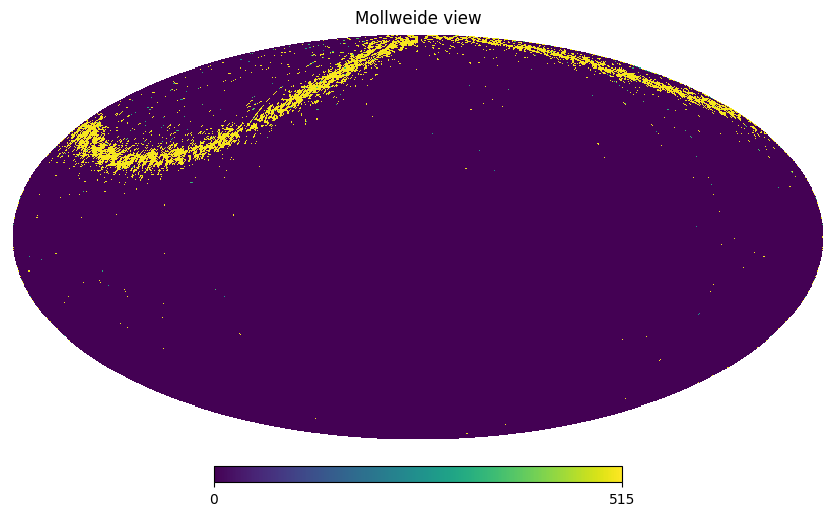

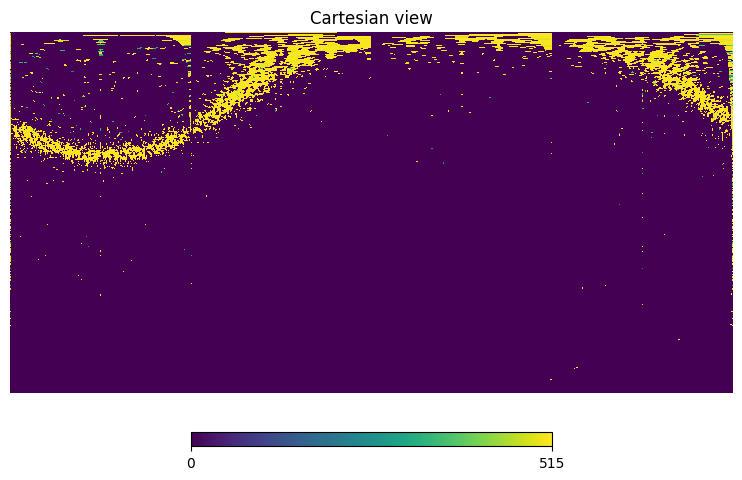

In [97]:
def denoise_cart(img):
    new_img = []
    for r in range(len(img)):
        new_img.append([])
    
    for r in range(len(img)):
        for c in range(len(img[0])):
            if r >= len(img) - 2 or c >= len(img[0]) - 2:
                new_img[r].append(img[r][c])
                continue

            # if img[r][c] >= 1 and (img[r + 1][c] >= 1 and img[r - 1][c] >= 1) or (img[r][c + 1] >= 1 and img[r][c - 1] >= 1):
            #     new_img[r].append(img[r][c])
            if img[r][c] >= 1 and (img[r + 1][c] >= 1 and img[r - 1][c] >= 1 and img[r + 2][c] >= 1 and img[r - 2][c] >= 1) or (img[r][c + 1] >= 1 and img[r][c - 1] >= 1 and img[r][c + 2] >= 1 and img[r][c - 2] >= 1):
                new_img[r].append(img[r][c])
            else:
                new_img[r].append(0)
    


    return np.asarray(new_img)

denoised = denoise_cart(cart_arr)

reconstructed = reconstruct_from_cartesian(denoised, NSIDE, cart_to_heal_map)

hp.mollview(reconstructed)
hp.cartview(reconstructed)

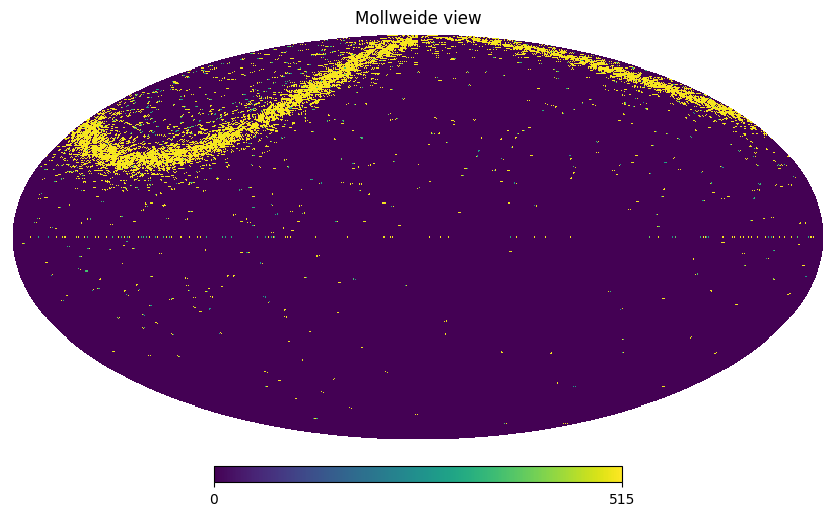

In [98]:
import sys
sys.path.append("../utils")
from utils import normalize, scale

def denoise(arr, THRESHOLD):
    new_arr = []
    for i in range(len(arr) - 1):
        if arr[i - 1] < THRESHOLD and arr[i + 1] < THRESHOLD: 
            new_arr.append(0)
        else:
            new_arr.append(arr[i])
    
    # Add last element
    new_arr.append(arr[-1])

    return np.asarray(new_arr)

denoised_old = denoise(healpix_arr, 50)
hp.mollview(denoised_old)

In [87]:
print(f"My Reconstruction Denoising: {np.average(reconstructed - healpix_arr)}" )
print(f"Old Denoising : {np.average(denoised_old - healpix_arr)}" )

My Reconstruction Denoising: -27.189427693684895
Old Denoising : -20.898468017578125


255


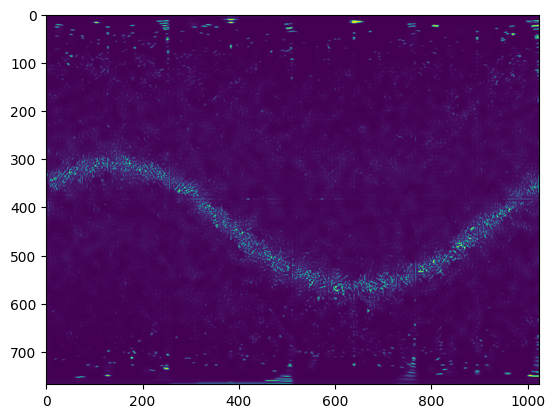

In [55]:
# CV2 denoising

import cv2

cv2_arr = (cart_arr - np.min(cart_arr)) / np.max(cart_arr) * 255


# # Reshape to explicitly say one channel
# cv2_arr = np.reshape(cv2_arr, (1, cv2_arr.shape[0], cv2_arr.shape[1]))
cv2_arr = np.uint8(cv2_arr)

# normalized_array = cv2.normalize(cv2_arr, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# plt.imshow(cv2_arr)

print(np.max(cv2_arr))

# gray_arr = cv2.cvtColor(cart_arr, cv2.COLOR_BGR2GRAY)

denoised = cv2.fastNlMeansDenoising(cv2_arr, None, 60, 7, 21)

plt.imshow(denoised)

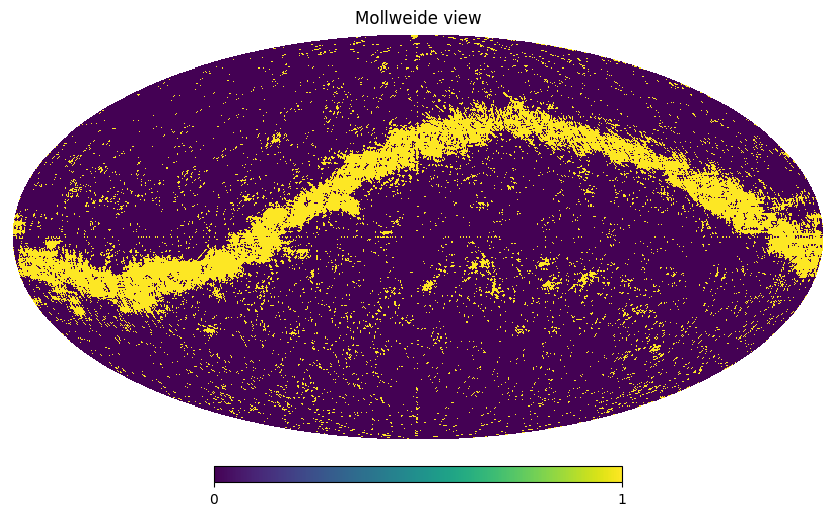

In [74]:

reconstructed_CV = reconstruct_from_cartesian(denoised, NSIDE, cart_to_heal_map)

for i in range(len(reconstructed_CV)):
    if reconstructed_CV[i] > 10:
        reconstructed_CV[i] = 1
    else:
        reconstructed_CV[i] = 0
 
hp.mollview(reconstructed_CV)